In [6]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator


In [7]:
def draw_image(subplot, image, title):
    plt.subplot(subplot)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

In [8]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [9]:
len(train_df)

9850

In [10]:
counts = train_df['Id'].value_counts()
len(counts[counts>10])

57

In [11]:
len(counts)-len(counts[counts<=10])

57

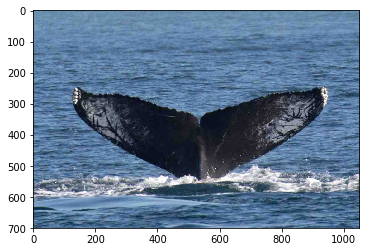

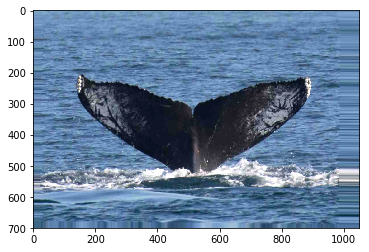

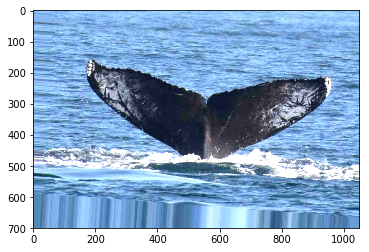

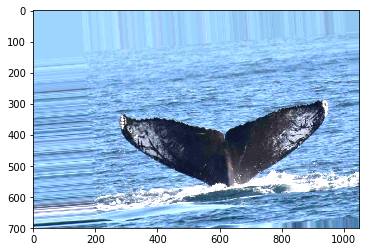

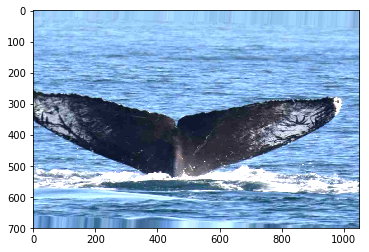

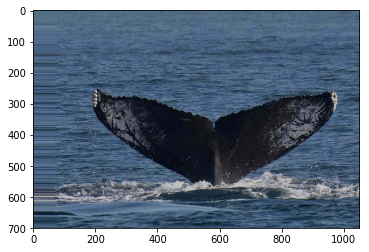

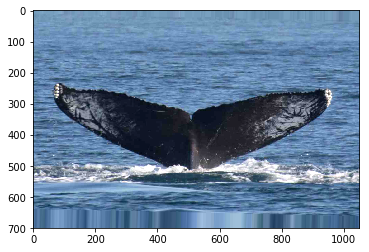

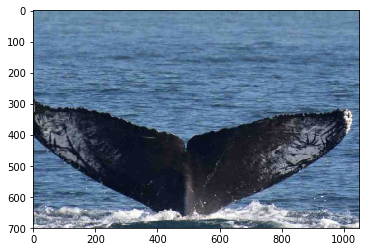

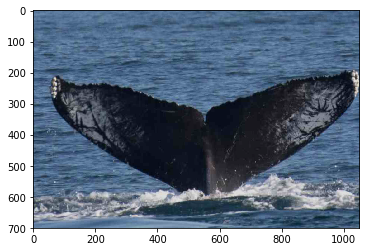

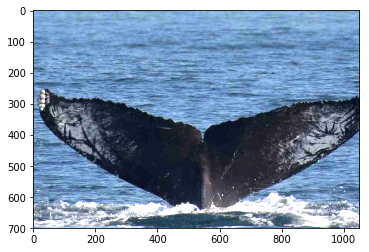

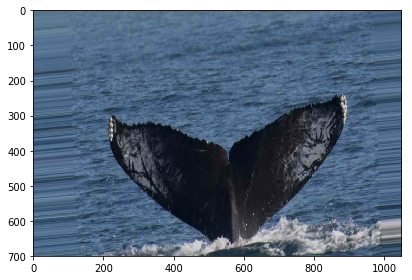

In [12]:
# datagen_args = dict(rotation_range=10,
#                     width_shift_range=0.1,
#                     height_shift_range=0.1,
#                     shear_range=-1,
#                     zoom_range=0.3,
#                     horizontal_flip=False)
datagen_args = dict(featurewise_center=False, 
                    samplewise_center=False, 
                    featurewise_std_normalization=False, 
                    samplewise_std_normalization=False, 
                    zca_whitening=False, 
                    zca_epsilon=1e-06, 
                    rotation_range=5, 
                    width_shift_range=0.1, 
                    height_shift_range=0.1, 
                    brightness_range=(0.75,1.5), 
                    shear_range=0.4, 
                    zoom_range=0.3, 
                    channel_shift_range=0, 
                    fill_mode='nearest', 
                    cval=0.0, 
                    horizontal_flip=False, 
                    vertical_flip=False, 
                    rescale=None, 
                    preprocessing_function=None, 
                    data_format=None, 
                    validation_split=0.0)
datagen = ImageDataGenerator(**datagen_args)

sid = 150
np.random.seed(0)
original = plt.imread('./data/train/1e5c6493.jpg')
sid += 1
plt.figure()
plt.imshow(original, cmap='gray')
for j in range(10):
    augmented = datagen.random_transform(original)
    augmented = augmented.astype(np.uint8)
    sid += 1
    plt.figure()
    plt.imshow(augmented, cmap='gray')
#     draw_image(sid, augmented, "aug#{:d}".format(j + 1))

plt.tight_layout()
plt.show()

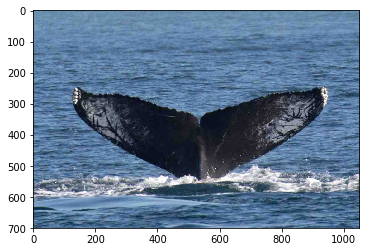

In [14]:
img = plt.imread('./data/train/1e5c6493.jpg')
from keras.preprocessing.image import random_shear
plt.imshow(img, cmap='gray')

In [15]:
original.shape

(700, 1050, 3)

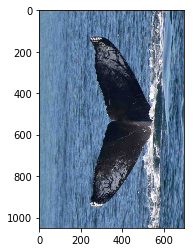

In [19]:
img1 = img.transpose(1,0,2)
plt.imshow(img1, cmap='gray')

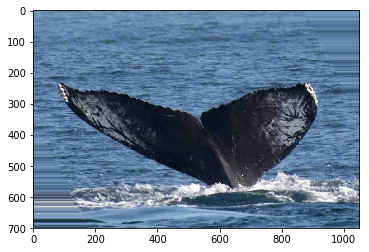

In [20]:
img2 = random_shear(img1, 30, row_axis=0, col_axis=1, channel_axis=2)
img2 = img2.transpose(1,0,2)
plt.imshow(img2, cmap='gray')

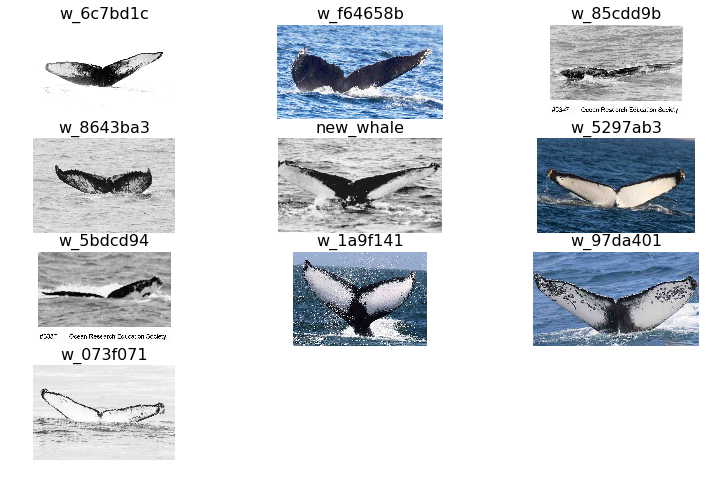

In [234]:
rand_rows = train_df[(train_df['aspect']>0.5) & (train_df['aspect']<0.75)].sample(frac=1.)[:10]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

### RGB to Grayscale

In [666]:
def grayscale_image(img):
    B = img[:,:,0]
    G = img[:,:,1]
    R = img[:,:,2]
    Bn = 16*np.sqrt(B)
    Gn = 16*np.sqrt(G)
    grayscaled = np.stack([B,G,R],axis=2)
    return grayscaled.max(axis=2)

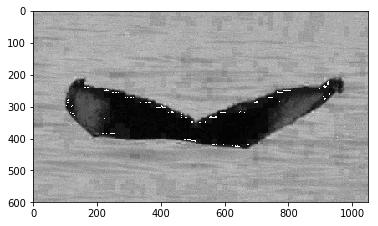

In [687]:
B = img[:,:,0]
G = img[:,:,1]
R = img[:,:,2]
Bn = 2*B-R
Gn = 2*G-R
grayscaled = np.stack([R,Gn,Bn],axis=2)
plt.imshow(np.uint8(grayscaled.max(axis=2)), cmap='gray')

In [685]:
B-np.max(0,(B-R)/255)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

TypeError: only size-1 arrays can be converted to Python scalars

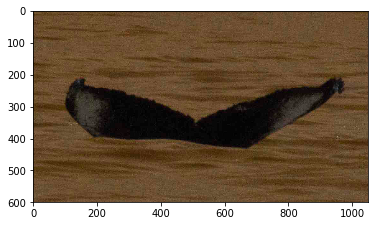

In [667]:
img_name = '0b1d25f5.jpg'
# load image to OpenCV as gray scale (parameter "0")
img = cv2.imread('./data/train/'+img_name) 
plt.imshow(img, cmap='gray')
# cv2.imwrite( "grey.png", img )
plt.imshow(grayscale_image(img), cmap='gray')

In [651]:
grayscale_image(img).shape

(599, 1050)

In [642]:
B = img[:,:,0]
G = img[:,:,1]
R = img[:,:,2]
B = (B+128)/2
G = (G+128)/2
blue_img = np.stack([B,G,R],axis=2)

In [643]:
B.max()

127.5

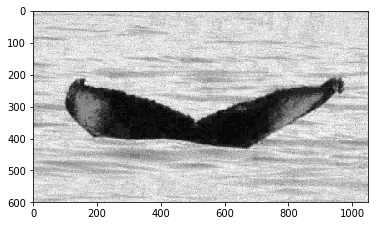

In [644]:
plt.imshow(blue_img.max(axis=2), cmap='gray')


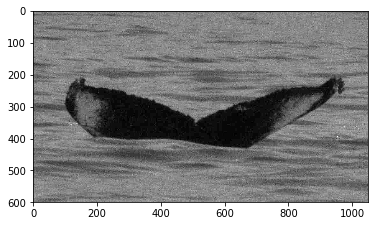

In [562]:
gray_img = cv2.imread('./data/train/'+img_name, 0) 
plt.imshow(gray_img, cmap='gray')

### Add padding

In [474]:
def pad_image(img):
    V = img.shape[0]
    H = img.shape[1]
    top = int(0.5*(H//2-V))
    bottom = top
    left = 0
    right = 0
    img_pad = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=225)
    return img_pad

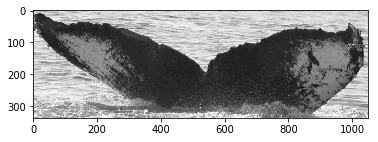

In [475]:
img_name = '0fcbbfeb.jpg'
img = cv2.imread('./data/train/'+img_name,0)
plt.imshow(img, cmap='gray')

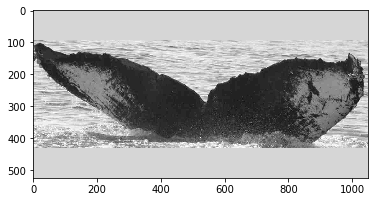

In [476]:
padded = pad_image(img)
plt.imshow(img_pad, cmap='gray')

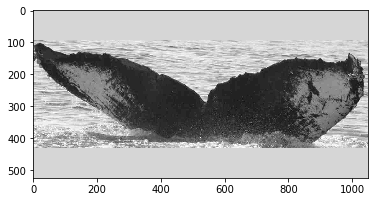

In [244]:
# add light gray padding (225 brightness) 
# only apply to images with aspect ratio narrower than 1:2
H = img.shape[0]
W = img.shape[1]
top = int(0.5*(W//2-H))
bottom = top
left = 0
right = 0
img_pad = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=225)
plt.imshow(img_pad, cmap='gray')

### Cropping images

In [589]:
def crop_image(img):
    canny_edges = cv2.Canny(img,300,300)
    edge_ratio = canny_edges.sum()/img.shape[0]/img.shape[1]
    if edge_ratio < 0.5:
        canny_edges = cv2.Canny(img,150,150)
    vcdf = np.cumsum(canny_edges.sum(axis=1)/canny_edges.sum())
    hcdf = np.cumsum(canny_edges.sum(axis=0)/canny_edges.sum())
    top = max(0, np.searchsorted(vcdf, 0.1, side="left")-100)
    left = max(0, np.searchsorted(hcdf, 0.1, side="left")-100)
    right = min(img.shape[1], np.searchsorted(hcdf, 0.9, side="left")+100)
    bottom = min(img.shape[0], top+(right-left)//2)
    cropped = img[top:bottom,left:right]
    return cropped

In [3]:
name_list = ['00f22419.jpg',
             '0acce63b.jpg',
             '0bc1562c.jpg',
             '0e891ec9.jpg',
             '0e8ce258.jpg',
             '1b36d7bb.jpg',
             '1b089ea6.jpg',
             '1b11b397.jpg',
             '000466c4.jpg',
             '0fcbbfeb.jpg',
             '0a0bc259.jpg',
             '0dd07e82.jpg',
             '0e672fdd.jpg',
             '0b352859.jpg',
             '7b077a97.jpg','0d4e8a7e.jpg']

In [4]:
img = cv2.imread('./data/train/'+name_list[5],0)
img.shape

(259, 454)

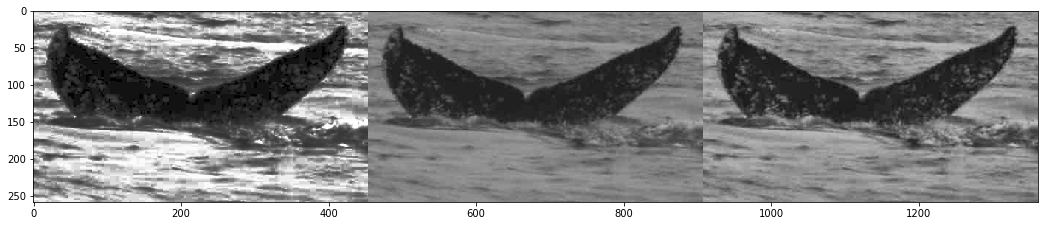

In [5]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10,10))
cl1 = clahe.apply(img)
equ = cv2.equalizeHist(img)
comp = np.hstack((equ,img,cl1)) #stacking images side-by-side
plt.figure(figsize=(18,5))
plt.imshow(comp,cmap='gray')

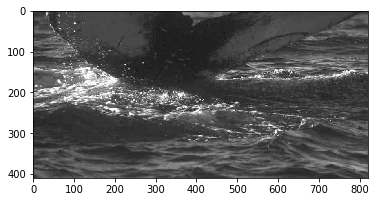

In [734]:
cropped = crop_image(img)
plt.imshow(cropped,cmap='gray')

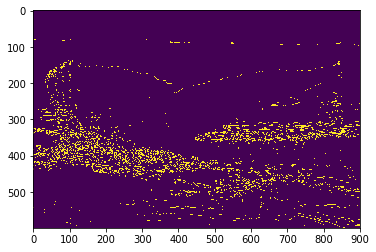

In [736]:

canny_edges = cv2.Canny(img,150,150)
plt.figure
plt.imshow(canny_edges)

In [737]:
canny_edges.sum()/img.shape[0]/img.shape[1]

12.90230940456316

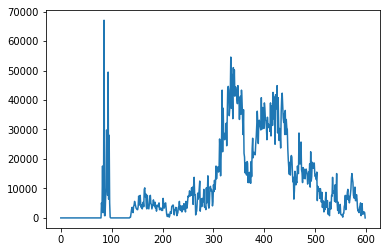

In [738]:
plt.plot(canny_edges.sum(axis=1))

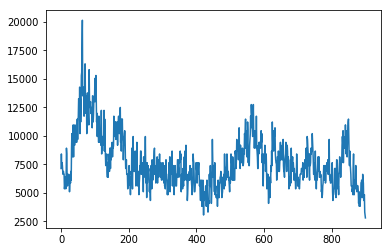

In [739]:
plt.plot(canny_edges.sum(axis=0))

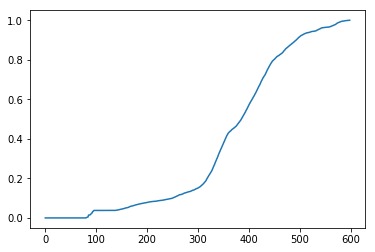

In [740]:
vcdf = np.cumsum(canny_edges.sum(axis=1)/canny_edges.sum())
plt.plot(vcdf)

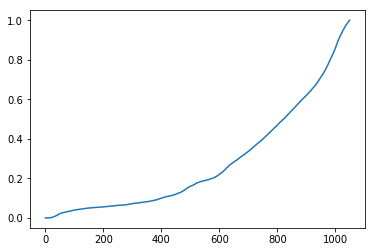

In [698]:
hcdf = np.cumsum(canny_edges.sum(axis=0)/canny_edges.sum())
plt.plot(hcdf)

In [702]:
top = max(0, np.searchsorted(vcdf, 0.1, side="left")-50)
left = max(0, np.searchsorted(hcdf, 0.05, side="left")-50)
right = min(img.shape[1], np.searchsorted(hcdf, 0.95, side="left")+50)
bottom = min(img.shape[0], top+(right-left)//2)


In [703]:
[top, bottom, left, right]

[68, 543, 99, 1050]

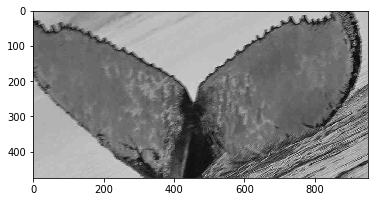

In [704]:
cropped = img[top:bottom,left:right]
plt.imshow(cropped, cmap='gray')

### Put everything together

In [6]:
import numpy as np
import cv2
import os
from tqdm import tqdm


def grayscale_image(img):
    B = img[:,:,0]
    G = img[:,:,1]
    R = img[:,:,2]
#     B = B*0.5+(255-R)*0.5
#     G = G*0.5+(255-R)*0.5
    grayscaled = np.stack([B,G,R],axis=2)
    return grayscaled.max(axis=2)

def pad_image(img):
    V = img.shape[0]
    H = img.shape[1]
    top = int(0.5*(H//2-V))
    bottom = top
    left = 0
    right = 0
    img_pad = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=200)
    return img_pad

def crop_image(img):
    canny_edges = cv2.Canny(img,300,300)
    edge_ratio = canny_edges.sum()/img.shape[0]/img.shape[1]
    if edge_ratio < 0.5:
        canny_edges = cv2.Canny(img,150,150)
    vcdf = np.cumsum(canny_edges.sum(axis=1)/canny_edges.sum())
    hcdf = np.cumsum(canny_edges.sum(axis=0)/canny_edges.sum())
    left = max(0, np.searchsorted(hcdf, 0.05, side="left")-50)
    right = min(img.shape[1], np.searchsorted(hcdf, 0.95, side="left")+50)
    top = max(0, np.searchsorted(vcdf, 0.075, side="left")-75)
    bottom = min(img.shape[0], top+(right-left)//2)
    top = min(top, bottom-(right-left)//2)
    cropped = img[top:bottom,left:right]
    return cropped

def enhance_image(img):
    GridSize = img.shape[1]//100
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(GridSize,GridSize))
    enhanced = clahe.apply(img)
    return enhanced

def main():
    INPUT_DIR = './data/train/'
    OUTPUT_DIR = './data/train_processed_new/'
    for file in tqdm(os.listdir(INPUT_DIR)):
        img = cv2.imread(INPUT_DIR+file)
        img = grayscale_image(img)
        img = np.uint8(img)
        V,H = img.shape
        if V != H and H > 300:
            if V >= H//2:
                new_img = crop_image(img)
            else:
                new_img = img
#                 new_img = pad_image(img)
        new_img = enhance_image(new_img)
        new_file_path = OUTPUT_DIR+file
        cv2.imwrite(new_file_path, new_img)

# This is the standard boilerplate that calls the main() function.
if __name__ == '__main__':
    main()

100%|██████████| 9850/9850 [04:22<00:00, 37.56it/s]
